In [21]:
#! pip install ipynb
#! pip install matplotlib
from ipynb.fs.full.deck_visualization import visualize_deck as vd
import random, copy

# Provide a non-interactive short ZK argument that shows that you have solved a Sudoku puzzle

For this assignment, we have used the following paper as concept: https://www.tains.tohoku.ac.jp/netlab/mizuki/conf/zerosuno_fct2023_web.pdf

The basic idea is to use 2 deck of UNO cards, with that we have 3 colored number cards (and not 2 as in the French-suited playing cards). In reality we have 4 distinct colors (yellow, red, blue and green), but we use the green ones as helping cards.

To create a valid verification, we require:
- 3 sets of Yellow cards from 1-9 (Y)
- 3 sets of Red cards from 1-9 (R)
- 3 sets of Blue cards from 1-9 (B)

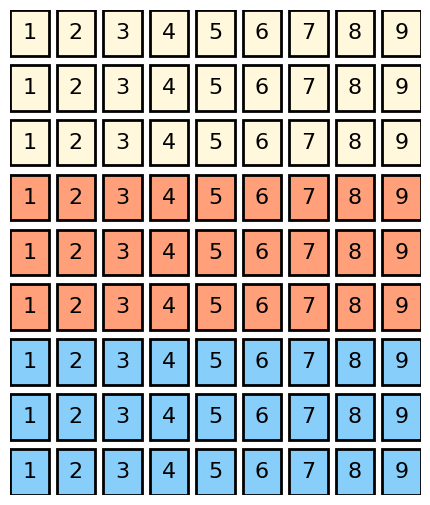

In [29]:
a = [[{"number" : i, "color" : 'cornsilk'} for i in range(1,10)],
    [{"number" : i, "color" : 'lightsalmon'} for i in range(1,10)], 
    [{"number" : i, "color" : 'lightskyblue'} for i in range(1,10)]]
vd([a[0],a[0],a[0],a[1],a[1],a[1],a[2],a[2],a[2]])

## Step 1: Get a Sudoku

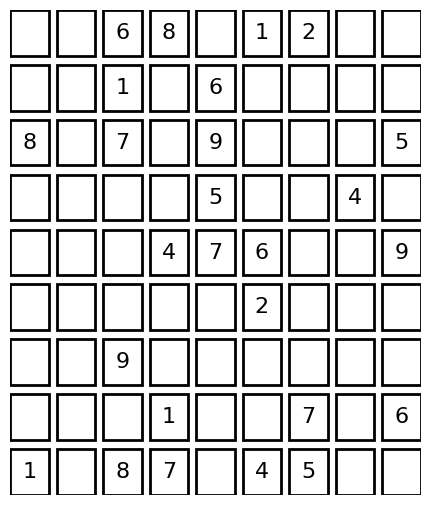

In [3]:
table = open("sudokus/01.txt", "r")
table = table.read()
deck = []
for idx, row in enumerate(table.split('\n')):
    temp = []
    for x in row:
        num = ''
        if x == '0':
            num = ' '
        else:
            num = x
        temp.append({"number": num, "color": "white"})
    deck.append(temp)
vd(deck)

## Step 1.1: A Prover (P) commits a solution

The Prover (P) has to provide a solution for the given task.

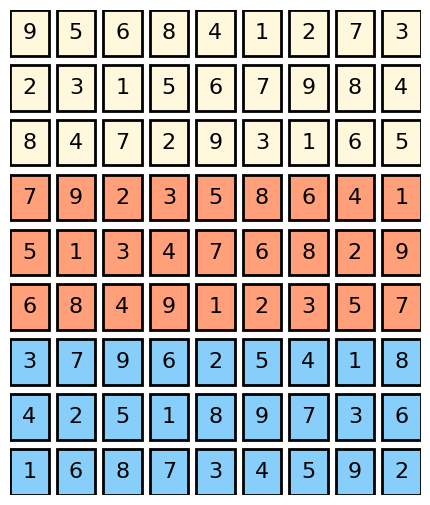

In [4]:
table = open("sudokus/01_sol.txt", "r")
table = table.read()
deck = []
colors = ["cornsilk", "lightsalmon", "lightskyblue"]
color = 0
for idx, row in enumerate(table.split('\n')):
    temp = []
    for x in row:
        num = ''
        if x == '0':
            num = ' '
        else:
            num = x
        temp.append({"number": num, "color": colors[color]})
    if idx % 3 == 2:
        color += 1
    deck.append(temp)
vd(deck)

The blocks (3 x 3 grids) are named from top left to bottom right as follows:

```
A | B | C
---------
D | E | F
---------
G | H | I
```


## Preliminaries

### Pile-Scramble Shuffle

Felbontja a paklit $k$ részcsoportra, és ezeket keveri meg random módon.

In [5]:
def pile_shuffle(deck, k):
    split_by_k = []
    k_temp = 0
    temp = []
    for card in deck:
        temp.append(card)
        k_temp += 1
        if k_temp == k:
            split_by_k.append(temp)
            temp = []
            k_temp = 0
    
    return [card for pile in random.sample(split_by_k, len(split_by_k)) for card in pile]

### Uniqueness Verification Protocol

In [6]:
# Helper functions

# Given 2 arrays, merge them into a single array by alternating elements from each array
# Example:
# deck1: [1,2,3]
# deck2: [4,5,6]
# result: [1,4,2,5,3,6]
def merge_decks(deck1, deck2):
    temp = []
    for x in range(0,len(deck1)):
        temp.append(deck1[x])
        temp.append(deck2[x])
    return temp

# Given a deck, split it into 2 decks by alternating elements from the original deck
# Example:
# deck: [1,4,2,5,3,6]
# deck1: [1,2,3]
# deck2: [4,5,6]
def split_decks(deck):
    deck1 = []
    deck2 = []
    for idx, card in enumerate(deck):
        if idx % 2 == 0:
            deck1.append(card)
        else:
            deck2.append(card)
    return deck1, deck2

# Create a "?" row with a given number of columns
# Example:
# empty_row(2)
# [{"number": "?", "color": "white"}, {"number": "?", "color": "white"}]
def empty_row(num):
    return [{"number": "?", "color": "white"} for _ in range(0, num)]

In [62]:
# Uniqueness Ver. Prot. with Visualizing the Deck (vd)
def unique_with_vd(deck):
    k = len(deck)
    # Create the helper deck with numbers 1-9
    help_deck = []
    for x in range(1,len(deck)+1):
        help_deck.append({"number": x, "color": "white"})

    # We need to merge the normal and the helping deck
    # so we can shuffle them together by pairs (k = 2)
    print('Deck is shuffled with pile shuffle, we can check if 1-9 numbers are present only once')
    merged = pile_shuffle(merge_decks(deck, help_deck), 2)
    deck1, deck2 = split_decks(merged) # we just have to split it, so we can draw it out
    vd([deck1, empty_row(k)])

    # Here we check if 1-9 cards are present only once of each color
    checker = copy.deepcopy(a)
    checker = checker[0] + checker[1] + checker[2]
    for x in deck1:
        found = False
        for card in checker:
            if int(card["number"]) == int(x["number"]) and card["color"] == x["color"]:
                checker.remove(card)
                found = True
                break
        if not found:
            print('There is a duplicate in the deck or an unexpected card.')
            print('Problematic card:', x)
            print('Remaining checker:', checker)
            return False

    # We have to shuffle again, so won't know the orders
    print('Deck is shuffled again, now the helping deck is revealed, so we can sort it to the original state')
    deck1, deck2 = split_decks(pile_shuffle(merged, 2))
    vd([empty_row(k), deck2])

    # We have to sort the revealed helping deck, so we can restore the original sequence
    print("Sort the helping deck, so the row is restored to the original sequence without knowing the exact order")
    paired_decks = list(zip(deck1, deck2))
    sorted_paired_decks = sorted(paired_decks, key=lambda x: x[1]['number'])
    sorted_deck1, sorted_deck2 = zip(*sorted_paired_decks)
    sorted_deck2 = list(sorted_deck2)

    #vd([sorted_deck1, sorted_deck2])
    vd([empty_row(k), sorted_deck2])

    return True

In [66]:
# This is the same as the unique_with_vd function, but without the visualization
def unique(deck):
    # Creating the helper deck
    help_deck = []
    for x in range(1,len(deck)+1):
        help_deck.append({"number": x, "color": "white"})
    
    # Merging the decks and shuffling them
    merged = pile_shuffle(merge_decks(deck, help_deck), 2)
    deck1, _ = split_decks(merged)

    # Here we check if 1-9 cards are present only once of each color
    checker = copy.deepcopy(a)
    checker = checker[0] + checker[1] + checker[2]
    for x in deck1:
        found = False
        for card in checker:
            if int(card["number"]) == int(x["number"]) and card["color"] == x["color"]:
                checker.remove(card)
                found = True
                break
        if not found:
            print('There is a duplicate in the deck or an unexpected card.')
            print('Problematic card:', x)
            print('Remaining checker:', checker)
            return False   
    return True

## Sub-protocols

### Color Verification Sub-protocol

In [9]:
def color_ver(deck):
    return True

### 3-row Verification Sub-protocol

In [67]:
def row_ver(deck):
    for i in range(0,3):
        row1 = deck[i]
        row2 = deck[i+3]
        row3 = deck[i+6]
        rows = row1 + row2 + row3
        if not unique(rows):
            print('Duplicate in rows')
            print(rows)
            return False
    return True

row_ver(deck)

True

Deck is shuffled with pile shuffle, we can check if 1-9 numbers are present only once


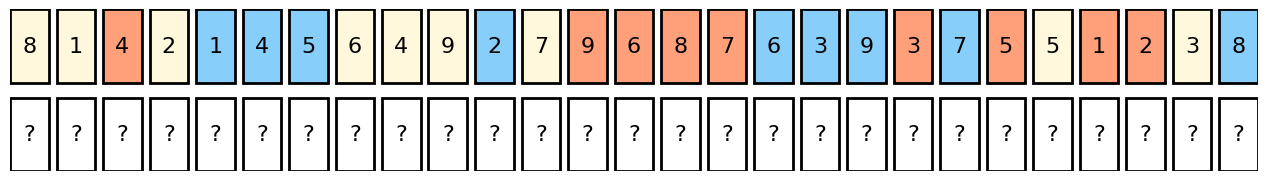

Deck is shuffled again, now the helping deck is revealed, so we can sort it to the original state


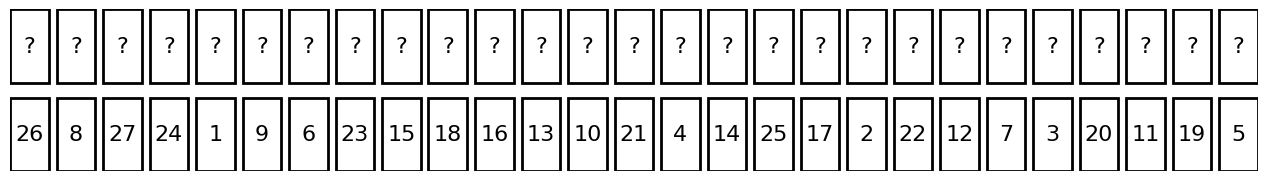

Sort the helping deck, so the row is restored to the original sequence without knowing the exact order


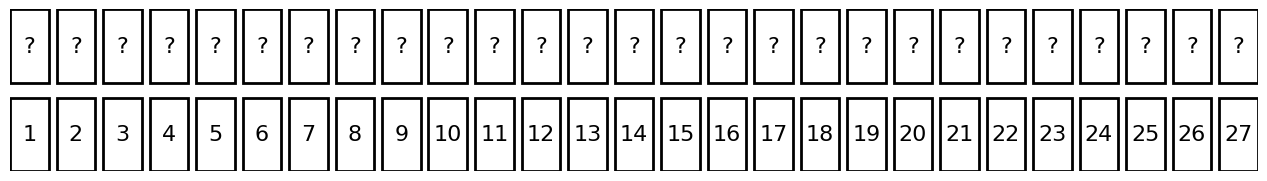

True

In [68]:
row1 = deck[0]
row2 = deck[3]
row3 = deck[6]
rows = row1 + row2 + row3
unique_with_vd(rows)

###  Color Change Sub-protocol

In [11]:
def color_change(deck):
    return True

### 3-column Verification Sub-Protocol

In [12]:
def col_ver(deck):
    return True

# The protocol for 9x9 Sudoku

> This is the proposed protocol for convincing a verifier that the numbers 1 to 9 appear exactly once in each row, each column, and each block. The number of required cards is 117 and the number of shuffles is 16 although we omit the breakdowns due to the space limitation.